# Embrace Randomness - in XGBoost

**IMPORTANT:** XGBoost is deterministic when the model parameters *subsample* and *colsample_by_** are set to the default values of 1.0.

Thus, running XGBoost with the default parameters will always return the same model (given the same training set as input). Even changing XGBoost's random state has no effect in this case - because it only comes into play when sampling is used.

However, to prevent overfitting it is common to test different values for the sampling parameters (e.g. during hyperparameter optimization). Consequently, XGBoost will generate different models for the same input data when trained repeatedly.

There are two ways to deal with the randomness:

1. set *random_state* to a fixed value - this is good for reproducability, but **not for production-ready models!** (TODO: add reference)
2. train the model many times with cross validation and choose the model with the highest mean score as final model, i.e. the model which achieves the best generalization on the given training and test data.

## Overview

In this notebook, we will

* Train XGBoost with default parameters (produces deterministic model).
* Train XGBoost with resampling (produces random model).
* Train XGBoost with cross validation.

## Pre-requisites

* Load dataset (breast cancer - clean data, no missing values, no features engineering necessary)
* Split into training and test data (70%/30%)

In [1]:
from time import time
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_breast_cancer()

# IMPORTANT: switch target labels as malignant should be 1

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = 1-pd.Series(data['target'], name='target')

labels = data['target_names'][[1,0]]

# Split training and test data

In [3]:
from sklearn.model_selection import train_test_split

random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)
print("train: ", X_train.shape, ', test:', X_test.shape)

train:  (398, 30) , test: (171, 30)


# Train XGBoost Models

## Deterministic Model: using default parameters

In [4]:
max_rounds = 100   # maximum number of boosting iterations
early_stop = 50    # stop if metric does not improve for X rounds

In [5]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

def train_xgb_sklearn(params, X_train, y_train, X_test, y_test, random_seed):
    '''Train and predict with Scikit-Learn XGBClassifier'''
    clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)
    clf.fit(X_train, y_train)
    return clf.predict_proba(X_test)[:,1]

def train_xgb_native(params, X_train, y_train, X_test, y_test, random_seed):
    '''Train '''
    params = {**params, 'seed':random_seed}
    train = xgb.DMatrix(X_train.values, y_train.values)
    test  = xgb.DMatrix(X_test.values, y_test.values)
    bst = xgb.train(params, train, max_rounds)
    return bst.predict(test)

In [6]:
def eval_metrics(y_true, y_hat):
    return {
        'roc': roc_auc_score(y_true, y_hat),
        'acc': accuracy_score(y_true, y_hat >= 0.5),
        'wrong': y_true[y_true != (y_hat >= 0.5)].index.values,
    }

def eval_n_times(n, xgb_train, params, verbose=True):
    print(f"RUNNING {n}-times '{xgb_train.__name__}' with {params}")
    results=[]
    for i in range(n):
        random_seed = np.random.randint(1000)
        y_hat = xgb_train(params, X_train, y_train, X_test, y_test, random_seed)
        metrics = {**eval_metrics(y_test, y_hat), 'seed':random_seed}
        results.append(metrics)
        if verbose:
            print("roc_auc={roc:.4f}, accuracy={acc:.4f}, wrong:{wrong}, seed:{seed}".format(**metrics))
    return results

In [7]:
# using default XGBoost parameters
# 'max_depth' and 'learning_rate' have to be set because xgb.train() and XGBClassifier use different defaults
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.1
}

for fun in [train_xgb_sklearn, train_xgb_native]:
    eval_n_times(5, fun, params);

RUNNING 5-times 'train_xgb_sklearn' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:117
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:981
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:360
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:770
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:720
RUNNING 5-times 'train_xgb_native' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:270
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:588
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:799
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:849
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:464


## Random Model - using subsample parameter

In [8]:
# using subsample in XGBoost parameters
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.1,
    'subsample':0.8,
}

for fun in [train_xgb_sklearn, train_xgb_native]:
    results = eval_n_times(10, fun, params);
    print("MEAN: roc_auc={roc:.4f}, accuracy={acc:.4f}".format(**pd.DataFrame(results).mean().to_dict()))

RUNNING 10-times 'train_xgb_sklearn' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
roc_auc=0.9974, accuracy=0.9766, wrong:[205  86  73 385], seed:817
roc_auc=0.9955, accuracy=0.9708, wrong:[205  86 193  73 385], seed:285
roc_auc=0.9950, accuracy=0.9825, wrong:[ 86  73 385], seed:272
roc_auc=0.9959, accuracy=0.9766, wrong:[205  86  73 385], seed:82
roc_auc=0.9956, accuracy=0.9766, wrong:[205  86  73 385], seed:94
roc_auc=0.9946, accuracy=0.9766, wrong:[ 86 193  73 385], seed:711
roc_auc=0.9966, accuracy=0.9766, wrong:[205  86  73 385], seed:695
roc_auc=0.9966, accuracy=0.9766, wrong:[ 86 193  73 385], seed:614
roc_auc=0.9955, accuracy=0.9708, wrong:[205  86 193  73 385], seed:744
roc_auc=0.9971, accuracy=0.9708, wrong:[205  86 193  73 385], seed:99
MEAN: roc_auc=0.9960, accuracy=0.9754
RUNNING 10-times 'train_xgb_native' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
roc_auc=0.9950, accuracy=0

# Cross Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from joblib import Parallel, delayed

# not possible to use early stopping with sklearn cross validate
def train_xgb_cv_sklearn(X_train, y_train, params, max_rounds, skb, random_seed):
    clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)
    results = cross_validate(clf, X_train, y_train, cv=skb, scoring=['roc_auc', 'accuracy'], n_jobs=4, return_train_score=False)
    roc, acc = pd.DataFrame(results).mean()[['test_roc_auc', 'test_accuracy']].values
    return {'roc':roc, 'acc':acc}

def train_xgb_cv_native(X_train, y_train, params, max_rounds, skb, random_seed):
    params = {**params, 'seed':random_seed}
    train = xgb.DMatrix(X_train.values, y_train.values)
    result = xgb.cv(params, train, max_rounds, folds=skb, metrics=['error','auc'])
    roc, err = result.iloc[-1][['test-auc-mean', 'test-error-mean']].values
    return {'roc':roc, 'acc':1-err}

def train_xgb_cv_custom(X_train, y_train, params, max_rounds, skb, random_seed):
    fold_results=[]
    params = {**params, 'seed':random_seed}
    train = xgb.DMatrix(X_train.values, y_train.values)
    for i,s in enumerate(skb.split(X_train,y_train)):
        fold_train = train.slice(s[0])
        fold_test  = train.slice(s[1])
        bst = xgb.train(params, fold_train, max_rounds)
        #xgb.train(params, train, max_rounds, evals=[(test, 'validation_0')], verbose_eval=True)
        y_hat = bst.predict(fold_test)
        metrics = eval_metrics(y_train.iloc[s[1]], y_hat)
        fold_results.append(metrics)
    return pd.DataFrame(fold_results).mean().to_dict()

def eval_n_times_cv(xgb_cv, X_train, y_train, n, params, nfold=5, verbose=True):
    print(f"RUNNING {n}x {nfold}-fold '{xgb_cv.__name__}' with {params}")
    results = []
    start = time()
    rs = np.random.RandomState(42)
    for i in range(n):
        random_seed = rs.randint(1000)
        skb = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_seed)
        metrics = xgb_cv(X_train, y_train, params, max_rounds, skb, random_seed)
        results.append(metrics)
        metrics = {**metrics, 'seed':random_seed}
        if (verbose != 0) & (i % verbose == 0):
            print(f"{i}:", "roc_auc={roc:.4f}, accuracy={acc:.4f}, seed={seed}".format(**metrics))

    print("took %.1f seconds" % (time() - start))
    return results

In [10]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.1
}

results = eval_n_times_cv(train_xgb_cv_sklearn, X_train, y_train, 100, params, verbose=10)
print("MEAN: roc_auc={roc:.4f}, accuracy={acc:.4f}".format(**pd.DataFrame(results).mean().to_dict()))

RUNNING 100x 5-fold 'train_xgb_cv_sklearn' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
0: roc_auc=0.9920, accuracy=0.9673, seed=102
10: roc_auc=0.9909, accuracy=0.9574, seed=466
20: roc_auc=0.9872, accuracy=0.9623, seed=661
30: roc_auc=0.9882, accuracy=0.9547, seed=276
40: roc_auc=0.9880, accuracy=0.9498, seed=58
50: roc_auc=0.9883, accuracy=0.9548, seed=957
60: roc_auc=0.9882, accuracy=0.9648, seed=646
70: roc_auc=0.9923, accuracy=0.9649, seed=776
80: roc_auc=0.9901, accuracy=0.9674, seed=508
90: roc_auc=0.9930, accuracy=0.9623, seed=1
took 20.2 seconds
MEAN: roc_auc=0.9898, accuracy=0.9577


In [11]:
results = eval_n_times_cv(train_xgb_cv_native, X_train, y_train, 30, params, verbose=10)
print("MEAN: roc_auc={roc:.4f}, accuracy={acc:.4f}".format(**pd.DataFrame(results).mean().to_dict()))

RUNNING 30x 5-fold 'train_xgb_cv_native' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
0: roc_auc=0.9920, accuracy=0.9673, seed=102
10: roc_auc=0.9909, accuracy=0.9574, seed=466
20: roc_auc=0.9872, accuracy=0.9623, seed=661
took 26.1 seconds
MEAN: roc_auc=0.9901, accuracy=0.9591


In [12]:
results = eval_n_times_cv(train_xgb_cv_custom, X_train, y_train, 100, params, verbose=10)
print("MEAN: roc_auc={roc:.4f}, accuracy={acc:.4f}".format(**pd.DataFrame(results).mean().to_dict()))

RUNNING 100x 5-fold 'train_xgb_cv_custom' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
0: roc_auc=0.9920, accuracy=0.9673, seed=102
10: roc_auc=0.9909, accuracy=0.9574, seed=466
20: roc_auc=0.9872, accuracy=0.9623, seed=661
30: roc_auc=0.9882, accuracy=0.9547, seed=276
40: roc_auc=0.9880, accuracy=0.9498, seed=58
50: roc_auc=0.9883, accuracy=0.9548, seed=957
60: roc_auc=0.9882, accuracy=0.9648, seed=646
70: roc_auc=0.9923, accuracy=0.9649, seed=776
80: roc_auc=0.9901, accuracy=0.9674, seed=508
90: roc_auc=0.9930, accuracy=0.9623, seed=1
took 33.3 seconds
MEAN: roc_auc=0.9898, accuracy=0.9577


## Cross Validation with early stopping

In [13]:
#params = {**params, 'seed':random_seed}
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.05,
}

#params['eval_metric']=['auc']
metrics=['auc']
nfold=5
max_rounds=1000

train = xgb.DMatrix(X_train.values, y_train.values)
test  = xgb.DMatrix(X_test.values, y_test.values)

In [14]:
def best_xgb_cv(params, train, max_rounds, nfold, metrics, early_stop, random_seed):
    results = xgb.cv(params, train, max_rounds, nfold, stratified=True, metrics=metrics, early_stopping_rounds=early_stop, seed=random_seed)
    #best_round = results.index[-1]
    return results[f'test-{metrics[-1]}-mean'].reset_index().values[-1]

cv_results = []
rs = np.random.RandomState(42)
start = time()
eval_rounds = 100

for i in range(eval_rounds):
    random_seed = rs.randint(1000)
    best_it, score = best_xgb_cv(params, train, max_rounds, nfold, metrics, early_stop, random_seed)
    cv_results.append({'best_round':best_it, 'best_score':score, 'seed':random_seed})
print("took %.1f seconds" % (time() - start))

took 82.8 seconds


In [15]:
df_cv = pd.DataFrame(cv_results)
df_cv.head()

,best_round,best_score,seed
0,66.0,0.990340,102
1,126.0,0.989756,435
2,249.0,0.989269,860
3,184.0,0.989830,270
4,71.0,0.992018,106


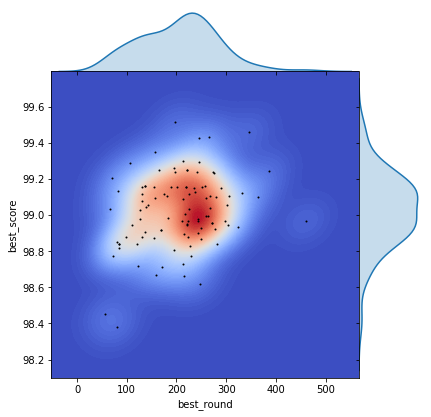

In [16]:
def joint_plot(x, y, title=None):
    g = sns.jointplot(x, y, kind="kde", space=0, n_levels=100, cmap='coolwarm')
    #g.ax_joint.axhline(y=df_cv.best_score.median()*100, color='lightblue', linestyle='--')
    #g.ax_joint.axvline(x=df_cv.best_round.median(), color='lightblue', linestyle='--')
    g.plot_joint(plt.scatter, c="k", s=1, linewidth=1)
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=0.95)

joint_plot(df_cv.best_round, df_cv.best_score*100)

In [17]:
test_results = []
start = time()
for round in df_cv.best_round.astype(int):
    bst = xgb.train(params, train, round+1)
    y_hat = bst.predict(test)
    metrics = eval_metrics(y_test, y_hat)
    test_results.append(metrics)
print("took %.1f seconds" % (time() - start))

took 15.0 seconds


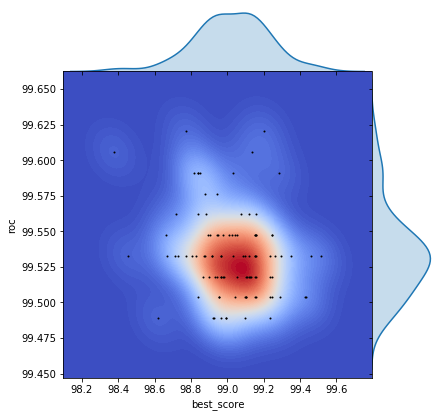

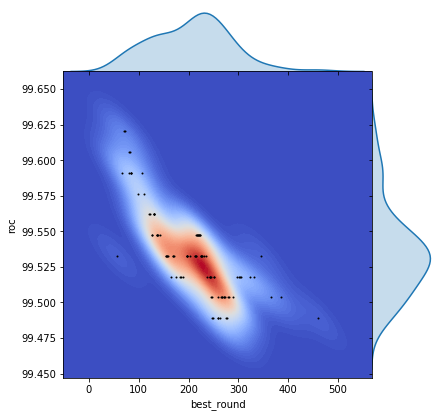

In [18]:
df_tst_res = pd.DataFrame(test_results)
joint_plot(df_cv.best_score*100, df_tst_res.roc*100)
joint_plot(df_cv.best_round, df_tst_res.roc*100)

In [19]:


max_rounds=500
params['eval_metric']=['auc']
skb = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_seed)

for s in skb.split(X_train,y_train):
    fold_train = train.slice(s[0])
    fold_test  = train.slice(s[1])
    #bst = xgb.train(params, fold_train, max_rounds)
    bst = xgb.train(params, fold_train, max_rounds, evals=[(fold_test, 'test')], verbose_eval=False, early_stopping_rounds=20)
    print('best_round', bst.best_iteration, 'best_score', bst.best_score)
    bst = xgb.train(params, train, bst.best_iteration+1)
    y_hat = bst.predict(test)
    metrics = eval_metrics(y_test, y_hat)
    print(metrics)

best_round 21 best_score 0.996
{'roc': 0.993063668224299, 'acc': 0.9473684210526315, 'wrong': array([205,   5,  86, 193, 100,  73, 375, 385,  99])}
best_round 8 best_score 0.975333
{'roc': 0.9904351635514019, 'acc': 0.9122807017543859, 'wrong': array([205,   5, 215, 196,  86,   7,  64, 193,  91, 100, 190,  73, 375,
       385,  99])}
best_round 13 best_score 0.996
{'roc': 0.9936477803738317, 'acc': 0.9298245614035088, 'wrong': array([205,   5, 215,  86, 193,  91, 100, 190,  73, 375, 385,  99])}
best_round 72 best_score 0.976552
{'roc': 0.9962032710280374, 'acc': 0.9707602339181286, 'wrong': array([  5,  86, 193,  73, 385])}
best_round 134 best_score 0.995862
{'roc': 0.9954731308411215, 'acc': 0.9649122807017544, 'wrong': array([205,   5,  86, 193,  73, 385])}


## With Hyperparameter Optimization

In [20]:
from sklearn.model_selection import GridSearchCV

def xgb_grid_search(space, X_train, y_train, params, max_rounds, skb, random_seed):
    clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)
    
    scoring = ['roc_auc']

    #print(f"xgb_cv '{key}', shape={X.shape}")
    start = time()

    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=space,
        n_jobs=4,
        cv=skb,
        scoring=scoring,
        verbose=0,
        refit=scoring[0],
        return_train_score=False,
    )

    fit_gs = grid_search.fit(X_train, y_train)
    print(fit_gs.best_params_, fit_gs.best_score_)

search_space = {
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],  # subsample of observations
    "colsample_bytree": [0.8, 1.0],  # subsample of features
    "learning_rate": [0.1, 0.05],
}

rs = np.random.RandomState(42)
for i in range(10):
    random_seed = rs.randint(1000)
    skb = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    xgb_grid_search(search_space, X_train, y_train, params, max_rounds, skb, random_seed)

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 0.9939005371686015
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.8} 0.9917651475769653
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1.0} 0.9905879974585572
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8} 0.9928169583549932
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.8} 0.9936556344943105
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8} 0.9953890140356958
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 0.9941569918558308
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8} 0.9932103043955409
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.8} 0.9936440824813725
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 0.9947